In [ ]:
"""
*******************************************************************************

Project: RL, assignment 2
File: warehouse_robot_dqn.ipynb
Author: Hamid Manouchehri
Email: hmanouch@buffalo.edu
Date: Mar 17, 2025

Description:

License:
This script is licensed under the MIT License.
You may obtain a copy of the License at
    https://opensource.org/licenses/MIT

SPDX-License-Identifier: MIT

Disclaimer:
This software is provided "as is", without warranty of any kind, express or
implied, including but not limited to the warranties of merchantability,
fitness for a particular purpose, and noninfringement. In no event shall the
authors be liable for any claim, damages, or other liability, whether in an
action of contract, tort, or otherwise, arising from, out of, or in connection
with the software or the use or other dealings in the software.

*******************************************************************************
"""

'\n*******************************************************************************\n\nProject: RL, assignment 1\nFile: warehouse_robot_Q_learning.ipynb\nAuthor: Hamid Manouchehri\nEmail: hmanouch@buffalo.edu\nDate: Feb 7, 2025\n\nDescription:\nCheckpoint 1, preparing an RL environment\nEnvironmet Scenario: Warehouse Robot\n\nLicense:\nThis script is licensed under the MIT License.\nYou may obtain a copy of the License at\n    https://opensource.org/licenses/MIT\n\nSPDX-License-Identifier: MIT\n\nDisclaimer:\nThis software is provided "as is", without warranty of any kind, express or\nimplied, including but not limited to the warranties of merchantability,\nfitness for a particular purpose, and noninfringement. In no event shall the\nauthors be liable for any claim, damages, or other liability, whether in an\naction of contract, tort, or otherwise, arising from, out of, or in connection\nwith the software or the use or other dealings in the software.\n\n*********************************

In [1]:
#!/usr/bin/env python3

import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import matplotlib.colors as mcolors
from IPython.display import clear_output
# from environment import WumpusWorldEnvironment
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from collections import deque
import random
import torch.optim as optim
import os

/home/hamid/miniconda3/envs/rl_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
################################
## Custom Function Definition ##
################################
def save_plot_as_img(png_plot_name, dir):
    """ Call this function after plt.plot(...)"""
    
    save_path = os.path.join(dir, png_plot_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    print(f"Plot saved at: {save_path}")

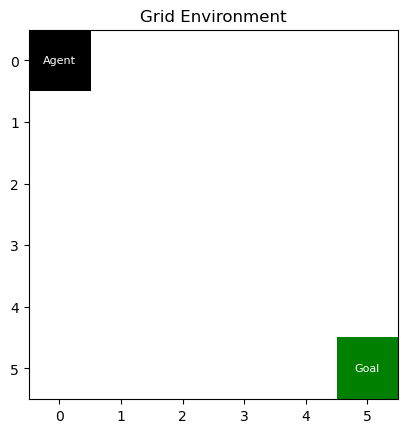

In [3]:
grid_size = 6
grid = np.ones((grid_size, grid_size, 3))
# Define grid size
grid_size = 6  # 6x6 grid

# Initialize grid with default background (White = 4)
grid = np.full((grid_size, grid_size), 1, dtype=int)  # Default to background

# Define agent and goal positions
init_agent_pos = [0, 0]  # Start position
goal_pos = [5, 5]  # Goal position

# Define integer-based color mapping
rgb_colors = {
    "black": 0,   # Agent
    "white": 1,   # Goal
    "red": 2,     # Trap
    "blue": 3,    # Water
    "green": 4,   # Background
    "gray": 5     # Obstacle
}

# Define color list for visualization
color_map = {
    0: "black",
    1: "white",
    2: "red",
    3: "blue",
    4: "green",
    5: "gray"
}

agent_obj_state = {
    0: "no_obj",
    1: "have_obj"
}

# Assign integer values to the grid
grid[tuple(init_agent_pos)] = rgb_colors["black"]  # Agent
grid[tuple(goal_pos)] = rgb_colors["green"]  # Goal

# Create a colormap using actual colors
cmap = mcolors.ListedColormap([color_map[i] for i in range(len(color_map))])

for i in range(6):  # rows
    for j in range(6):  # columns
        text = ""
        if [i, j] == init_agent_pos:
            text = "Agent"
        elif [i, j] == goal_pos:
            text = "Goal"
        
        # Only annotate if there is text to display
        if text:
            plt.text(j, i, text, ha="center", va="center", color="white", fontsize=8)


# Display the grid with correct colors
plt.imshow(grid, cmap=cmap, vmin=0, vmax=len(color_map) - 1)
plt.title("Grid Environment")
plt.show()


In [4]:
class GridEnvironment(gym.Env):
    metadata = {'render.modes': []}
    
    def __init__(self, max_timesteps):
        # Observation: [carry_flag, x, y]
        # carry_flag: 0 or 1, x: 0-5, y: 0-5
        self.observation_space = spaces.MultiDiscrete([2, 6, 6])
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_timesteps
        self.reward = 0
        
        self.timestep = 0
        self.agent_carry_obj = False
        self.agent_pos = [0, 0]
        self.goal_pos = [5, 5]
        self.object_pos = [1, 2]
        self.obstacle_1_pos = [2, 2]
        
        self.state = np.ones((6,6))
        self.state[tuple(self.agent_pos)] = rgb_colors["black"]
        self.state[tuple(self.goal_pos)] = rgb_colors["green"]
        self.state[tuple(self.object_pos)] = rgb_colors["blue"]
        self.state[tuple(self.obstacle_1_pos)] = rgb_colors["red"]
    
    def reset(self, **kwargs):
        self.agent_carry_obj = False
        self.agent_pos = [0, 0]
        self.goal_pos = [5, 5]
        self.object_pos = [1, 2]
        self.obstacle_1_pos = [2, 2]
        self.reward = 0
        self.timestep = 0
        self.state = np.ones((6,6))
        self.state[tuple(self.agent_pos)] = rgb_colors["black"]
        self.state[tuple(self.goal_pos)] = rgb_colors["green"]
        self.state[tuple(self.object_pos)] = rgb_colors["blue"]
        self.state[tuple(self.obstacle_1_pos)] = rgb_colors["red"]
        # Return observation as [carry_flag, x, y]
        observation = np.array([int(self.agent_carry_obj)] + self.agent_pos)
        info = {}
        return observation, info

    def pick_up_obj(self):
        self.state[tuple(self.object_pos)] = rgb_colors["white"]
        self.agent_carry_obj = True

    def drop_off_obj(self):
        self.state[tuple(self.goal_pos)] = rgb_colors["white"]
        self.agent_carry_obj = False

    def step(self, action):
        self.reward -= 1
        terminated = False
        
        # Compute potential new position based on action.
        new_agent_pos = self.agent_pos.copy()
        if action == 0:  # down
            new_agent_pos[0] += 1
        elif action == 1:  # up
            new_agent_pos[0] -= 1
        elif action == 2:  # right
            new_agent_pos[1] += 1
        elif action == 3:  # left
            new_agent_pos[1] -= 1
            
        # Ensure new position is within bounds.
        new_agent_pos = np.clip(new_agent_pos, 0, 5).tolist()
        
        # Obstacle avoidance: If new position equals the obstacle, apply penalty and do not move.
        if np.array_equal(new_agent_pos, self.obstacle_1_pos):
            self.reward -= 25
        else:
            self.agent_pos = new_agent_pos
        
        # Update grid state.
        self.state = np.ones((6,6))
        self.state[tuple(self.agent_pos)] = rgb_colors["black"]
        self.state[tuple(self.goal_pos)] = rgb_colors["green"]
        if not self.agent_carry_obj:
            self.state[tuple(self.object_pos)] = rgb_colors["blue"]
        self.state[tuple(self.obstacle_1_pos)] = rgb_colors["red"]
        
        # Create observation: [carry_flag, x, y]
        observation = np.array([int(self.agent_carry_obj)] + self.agent_pos)
        
        # Check for pickup.
        if np.array_equal(self.agent_pos, self.object_pos) and not self.agent_carry_obj:
            self.pick_up_obj()
            self.reward += 25
            self.state[tuple(self.object_pos)] = rgb_colors["black"]
        
        # Check for dropoff.
        if np.array_equal(self.agent_pos, self.goal_pos) and self.agent_carry_obj:
            self.drop_off_obj()
            self.reward += 100
            terminated = True
            self.state[tuple(self.goal_pos)] = rgb_colors["black"]
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps:
            terminated = True
        
        truncated = np.all((np.asarray(self.agent_pos) >= 0) & (np.asarray(self.agent_pos) <= 5))
        info = {}
        return observation, self.reward, terminated, truncated, info

    def render(self):
        # Optional: A simple rendering function for debugging.
        cmap = mcolors.ListedColormap([color_map[i] for i in range(len(color_map))])
        plt.imshow(self.state, cmap=cmap, vmin=0, vmax=len(color_map)-1)
        for i in range(6):
            for j in range(6):
                label = ""
                if np.array_equal([i, j], self.agent_pos):
                    label = "Agent"
                elif np.array_equal([i, j], self.goal_pos):
                    label = "Goal"
                elif np.array_equal([i, j], self.object_pos):
                    label = "Obj"
                elif np.array_equal([i, j], self.obstacle_1_pos):
                    label = "Obs"
                if label:
                    plt.text(j, i, label, ha="center", va="center", color="white", fontsize=8)
        plt.title("Grid Environment")
        plt.show()

/home/hamid/miniconda3/envs/rl_env/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


epsilon:  0.998
epsilon:  0.996004
epsilon:  0.994011992
epsilon:  0.992023968016
epsilon:  0.990039920079968
epsilon:  0.9880598402398081
epsilon:  0.9860837205593285
epsilon:  0.9841115531182099
epsilon:  0.9821433300119734
epsilon:  0.9801790433519495
epsilon:  0.9782186852652456
epsilon:  0.976262247894715
epsilon:  0.9743097233989256
epsilon:  0.9723611039521278
epsilon:  0.9704163817442236
epsilon:  0.9684755489807352
epsilon:  0.9665385978827737
epsilon:  0.9646055206870082
epsilon:  0.9626763096456342
epsilon:  0.9607509570263429
epsilon:  0.9588294551122902
epsilon:  0.9569117962020657
epsilon:  0.9549979726096616
epsilon:  0.9530879766644422
epsilon:  0.9511818007111134
epsilon:  0.9492794371096911
epsilon:  0.9473808782354717
epsilon:  0.9454861164790007
epsilon:  0.9435951442460427
epsilon:  0.9417079539575507
epsilon:  0.9398245380496356
epsilon:  0.9379448889735363
epsilon:  0.9360689991955893
epsilon:  0.9341968611971981
epsilon:  0.9323284674748037
epsilon:  0.930463810

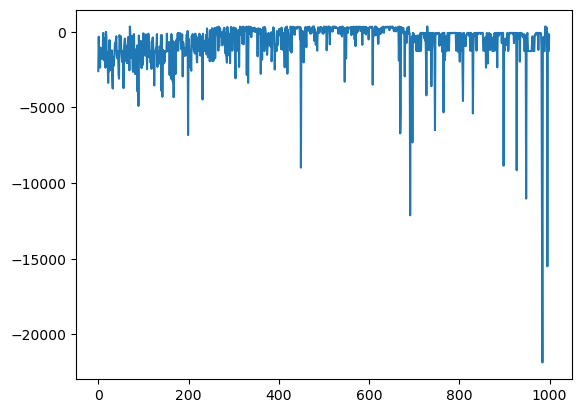

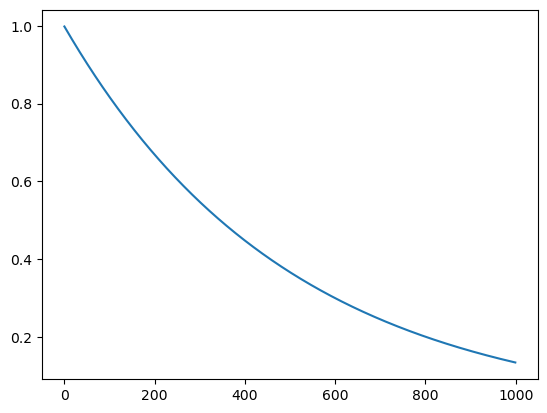

In [ ]:
##########################################
###### DQN, Observation Type: Vector #####
##########################################
num_of_episodes = 1000
max_steps = 50
learning_rate = 1e-2
min_epsilon = 0.1
epsilon_decay_factor = 0.998
batch_size = 32
gamma = 0.9
C = 20

# Define your neural network architecture.
class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)


    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


class DQN():

    def __init__(self, env):

        self.env = env
        self.D = deque([], maxlen=1000)  # replay memory

        self.Q_policy = NeuralNetwork()  # main network
        self.Q_prime = NeuralNetwork()  # target network
        self.Q_prime.load_state_dict(self.Q_policy.state_dict())

        self.init_epsilon = 1
        self.rewards = []
        self.epsilon_arr = []
        self.total_steps = 0

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.AdamW(self.Q_policy.parameters(), lr=learning_rate)

    
    def epsilon_greedy(self, prev_state):

        if self.init_epsilon > np.random.random():
            action = self.env.action_space.sample()

        else:
            q_values = self.Q_policy(torch.tensor(prev_state, dtype=torch.float32).unsqueeze(0))
            action = torch.argmax(q_values).item()
        
        return action
    

    def train_model(self):
        
        if len(self.D) < batch_size:
            return

        batch = random.sample(self.D, batch_size)

        states = torch.tensor([s[0] for s in batch], dtype=torch.float32)
        actions = torch.tensor([s[1] for s in batch], dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor([s[2] for s in batch], dtype=torch.float32)
        next_states = torch.tensor([s[3] for s in batch], dtype=torch.float32)
        dones = torch.tensor([s[4] for s in batch], dtype=torch.float32)
        
        current_q_values = self.Q_policy(states).gather(1, actions)
        
        next_q_values = self.Q_prime(next_states).max(1)[0]
        target_q_values = rewards + (1 - dones) * gamma * next_q_values
        target_q_values = target_q_values.unsqueeze(1)
        
        loss = self.criterion(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()


    def train(self):
        for episodes in range(num_of_episodes):

            prev_state, info = self.env.reset()
            ep_reward = 0

            for t in range(max_steps):
                
                action = self.epsilon_greedy(prev_state)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                ep_reward+=reward

                done = True if terminated else False

                self.D.append((prev_state, action, reward, next_state, done))

                self.train_model()

                prev_state = next_state
                self.total_steps += 1

                if t%C == 0:
                    self.Q_prime.load_state_dict(self.Q_policy.state_dict())

                if done:
                    break
            
            self.rewards.append(ep_reward)

            self.init_epsilon = max(min_epsilon, self.init_epsilon * epsilon_decay_factor)
            print("epsilon: ", self.init_epsilon)
            
            self.epsilon_arr.append(self.init_epsilon)

        print("episodes: ", episodes)


env = GridEnvironment(max_timesteps=500)
dqn_agent = DQN(env)
dqn_agent.train()

dir_to_save_data = "/home/hamid/UB/courses/sp2025/CSE546_RL/RL/data/test/"

plt.figure(1)
plt.plot(dqn_agent.rewards)
# save_plot_as_img('dqn_warehouse_robot_reward_per_episode.png', dir_to_save_data)

plt.figure(2)
plt.plot(dqn_agent.epsilon_arr)
# save_plot_as_img('dqn__warehouse_robot_epsilon_decay.png', dir_to_save_data)


Text(0.5, 1.0, 'total reward per episode, test agent, greedy actions')

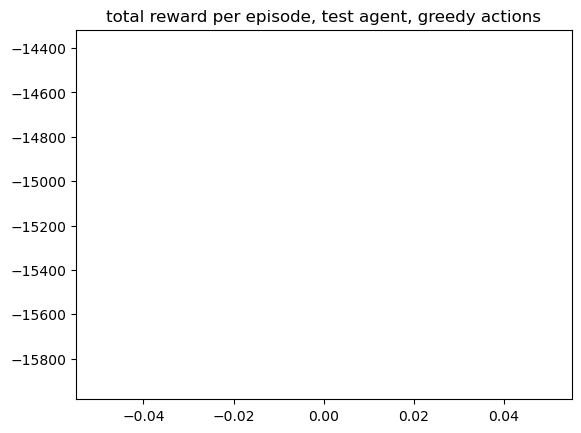

In [16]:
def test(nn, num_episodes=10, max_steps=50):
    from IPython.display import clear_output
    import time
    
    rewards_all_episodes = []
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        
        total_rewards = 0
        
        for step in range(max_steps):
            # Convert observation to a tensor and add batch dimension.
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            # Compute action using the network.
            action = torch.argmax(nn(obs_tensor)).item()
            
            # Execute action.
            obs, reward, terminated, truncated, info = env.step(action)
            total_rewards += reward
            
            # Render the environment.
            env.render()
            time.sleep(.1)  # Pause briefly so updates are visible.
            clear_output(wait=True)  # Clear previous output.
            # print(obs)
            if terminated:
                break
        
        rewards_all_episodes.append(total_rewards)
    
    return rewards_all_episodes

time.sleep(1)
t = test(dqn_agent.Q_policy, num_episodes=1, max_steps=200)
plt.figure(1)
plt.plot(t)
plt.title('total reward per episode, test agent, greedy actions')
# save_plot_as_img('dqn_warehouse_robot_reward_per_episod_5episodes.png', dir_to_save_data)

In [7]:

save_path = "test.pth"
torch.save(dqn_agent.Q_policy.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to test.pth
